# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [953]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
# % matplotlib inline

# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

### INITIAL DATA EXPLORATION

In [954]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


Lets check the different types of events in transcript column

In [955]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

The value column looks intresting, we will need to extract values from the "value" column. This we can do when we do data cleansing

In [956]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [957]:
portfolio.shape

(10, 6)

portfolio dataset has limited rows with different offers and some detail related to that

In [958]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [959]:
profile.shape

(17000, 5)

The Profile has details of users like age, gender and income which we can use for training our models

### DETAILED DATA EXPLORATION AND CLEANING

lets do detailed data exploration and some data cleansing

**PROFILE DATASET**

In [960]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [961]:
profile.isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

<AxesSubplot:xlabel='age'>

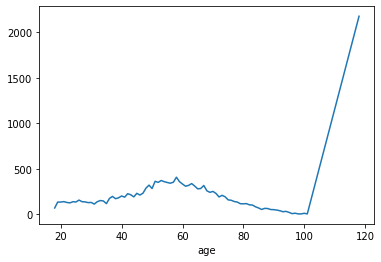

In [962]:
profile.groupby('age')['age'].count().plot()

As we can see there are 2175 null values in column gender and income and we also have 118 as age for more than 2000 users.

Lets drop columns with na values

In [963]:
profile = profile[profile['income'].notna()]

In [964]:
profile.isna().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

In [965]:
profile[profile['age'] == 118].count()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

After dropping NaN income columns, we find that gender NaN values and age with 118 have also been cleaerd along with it

**DIVIDING into AGE GROUPS**

to able to find some trend in the above data, lets divide all the ages into age groups

0-21 => teenager_adult(assuming non earning person) => label => 1

22-44 => young adult => label => 2

45-60 => adult => label => 3

60-100 => elder => label => 4

Lets also consider people above the age of 80, as outliers and remove from the dataset

In [966]:
profile = profile[profile['age']<=80]
profile['age_group'] = pd.cut(profile['age'], bins=[0,21,44,60,80], labels=[1,2,3,4])
profile.age_group.unique()

[3, 4, 2, 1]
Categories (4, int64): [1 < 2 < 3 < 4]



**Lets plot a graph for the income column as well**

<AxesSubplot:ylabel='Density'>

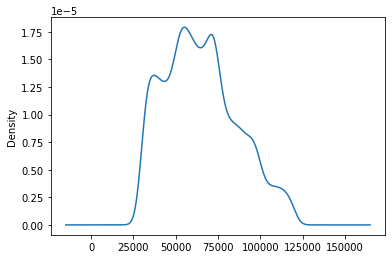

In [967]:
profile.income.plot(kind='kde')

In [968]:
profile['income_range'] = pd.cut(profile['income'], bins=[29999, 60000, 90000, 120001], labels=['average', 'above-average', 'high'])

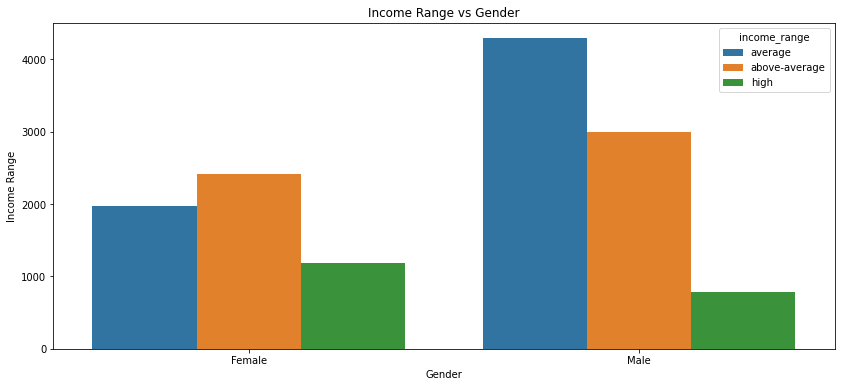

In [969]:
plt.figure(figsize=(14, 6))
g = sns.countplot(x="gender", hue="income_range", data= profile[profile["gender"] != 'O'])
plt.title('Income Range vs Gender')
plt.ylabel('Income Range')
xlabels = ['Female', 'Male']
g.set_xticklabels(xlabels)
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.show();

Here also we can divide the customers into income groups, Another option we have is to scale the income column using minmaxscaler, lets initially go with this minmaxscaler

In [970]:
scaler = MinMaxScaler()
profile['income_scaled'] = scaler.fit_transform(profile[['income']])
profile.head()

,gender,age,id,became_member_on,income,age_group,income_range,income_scaled
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,3,high,0.911111
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,4,high,0.777778
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,4,above-average,0.444444
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,4,average,0.255556
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,3,average,0.233333


**became_member_on**

This column can be used to find the customer age and this information can further help in our algorithm

In [971]:
profile['became_member_on'].head()

1     20170715
3     20170509
5     20180426
8     20180209
12    20171111
Name: became_member_on, dtype: int64

In [972]:
#the current became_member_on column is a str lets convert it into datetime column
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile['became_member_on'].sort_values(ascending=False).head()

1517    2018-07-26
452     2018-07-26
16423   2018-07-26
10282   2018-07-26
13249   2018-07-26
Name: became_member_on, dtype: datetime64[ns]

As we can see the last date in the dataset is 2018-07-26, lets take it as day 0, find customer age 

In [973]:
dataset_creation_date = pd.to_datetime('2018-07-27', format='%Y-%m-%d')
profile['membership_days'] = (dataset_creation_date - profile['became_member_on']).apply(lambda x: x.days)

**DIVIDE membership time into groups**

1-365 days ==> 1 year  ==> 1

366- 730 ==> 2 year ==> 2

731- 5000 ==> 2 year+ ===> 3

In [974]:
profile['membership_time'] = pd.cut(profile['membership_days'], bins=[0,365,730, 1000000], labels=[1, 2, 3])

In [975]:
profile.head()

,gender,age,id,became_member_on,income,age_group,income_range,income_scaled,membership_days,membership_time
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,3,high,0.911111,377,2
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,4,high,0.777778,444,2
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,4,above-average,0.444444,92,1
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,4,average,0.255556,168,1
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,3,average,0.233333,258,1


In [976]:
profile.age_group.unique()

[3, 4, 2, 1]
Categories (4, int64): [1 < 2 < 3 < 4]

Looking at the data, id column can be renamed to customer_id

In [977]:
profile.rename(columns={'id':'customer_id'}, inplace=True)

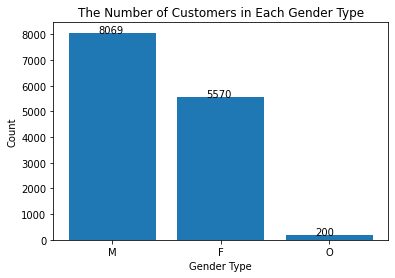

In [978]:
profile_gender_counts = profile.gender.value_counts()
x = ['M','F','O']
data = profile_gender_counts
plt.bar(x,height = data);
xlocs, xlabs = plt.xticks()
for i, v in enumerate(data):
    plt.text(xlocs[i] - 0.13, v , str(v))
plt.xlabel('Gender Type');
plt.ylabel('Count');
plt.title('The Number of Customers in Each Gender Type');

In [979]:
profile.head()

,gender,age,customer_id,became_member_on,income,age_group,income_range,income_scaled,membership_days,membership_time
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,3,high,0.911111,377,2
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,4,high,0.777778,444,2
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,4,above-average,0.444444,92,1
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,4,average,0.255556,168,1
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,3,average,0.233333,258,1


To run machine learning models we will need to convert gender string value to float

In [980]:
replace_gender = {'gender': {'F': 1, 'M': 2, 'O': 3}}
profile.replace(replace_gender, inplace=True)

**PORTFOLIO DATASET**

In [981]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


**ONE HOT ENCODING**

we should one hot encode channels columns

In [982]:
def do_one_hot_encoding(df, column_name):
    """
    method convert list column values into new columns with 1 and 0 if the value exists in the list
    this operation is also called one hot encoding
    
    params:
        df (DataFrame): dataframe on which you want to run the operation
        column_name (str): the list column name on which you want to run this operation
        
    returns:
        df (DataFrame): returns one hot encoded dataframe
    
    """
    mlb = MultiLabelBinarizer(sparse_output=True)

    df = df.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(df.pop(column_name)),
                index=df.index,
                columns=mlb.classes_))
    return df
portfolio = do_one_hot_encoding(portfolio, 'channels')

portfolio.head()

,reward,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


The duration column is in days, Lets convert it into hours, as during initial data analysis we saw time field in the transcript dataframe which is in hours

In [983]:
portfolio['duration_h'] = portfolio['duration'] * 24

In [984]:
portfolio.rename(columns={'id': 'offer_id'}, inplace=True)

In [985]:
portfolio.head()

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web,duration_h
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,168
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,120
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,96
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,168
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,240


**TRANSCRIPT DATASET**

In [986]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


We need to extract values from value dict and add it into columns in dataframe

In [987]:
def clean_transcript(df):
    """
    method cleans up transcript dataset. 
    the value column contains a dict, which has different values for different event type
    
    params:
        df (DataFrame): Dataframe to be cleaned
        
    returns:
        df (DataFrame): cleaned dataframe to be returned
    """
    df1 = df[df['event'] == 'offer received']
    df2 = df[df['event'] == 'offer viewed']
    df3 = df[df['event'] == 'transaction']
    df4 = df[df['event'] == 'offer completed']
    df4['offer_id'] = df4['value'].apply(lambda x: x.get('offer_id', None))
    df4['reward'] = df4['value'].apply(lambda x: x.get('reward', 0))
    df3['amount'] = df3['value'].apply(lambda x: x.get('amount', 0))
    df2['offer_id'] = df2['value'].apply(lambda x: x.get('offer id', None))
    df1['offer_id'] = df1['value'].apply(lambda x: x.get('offer id', None))
    df = pd.concat([df1,df2,df3,df4])
    df.drop(columns=['value'], inplace=True)
    return df

transcript = clean_transcript(transcript)

transcript.head(100)

/Users/nitinagarwal/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Users/nitinagarwal/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/nitinagarwal/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

,person,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN
...,...,...,...,...,...,...
95,7c8479d8241344f6a0c306621e191c75,offer received,0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
96,5404741ead9442bdbd4b9aa2273e85af,offer received,0,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN
97,81e9ad5fa55a4884b65e01a5db8f1b4e,offer received,0,ae264e3637204a6fb9bb56bc8210ddfd,NaN,NaN
98,ed46fca6de7042478b411690878dc069,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN


In [988]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306527
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   person    306534 non-null  object 
 1   event     306534 non-null  object 
 2   time      306534 non-null  int64  
 3   offer_id  167581 non-null  object 
 4   amount    138953 non-null  float64
 5   reward    33579 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 16.4+ MB


In [989]:
transcript.rename(columns={'person': 'customer_id'}, inplace=True)

Lets check if the transcript dataset consists of any duplicates

In [990]:
transcript.duplicated().sum()

397

In [991]:
transcript.drop_duplicates(inplace=True)

In [992]:
transcript.duplicated().sum()

0

**LETS MERGE DATASETS**

lets merge transcript and portfolio dataset

In [993]:
portfolio.head()

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web,duration_h
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,168
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,120
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,96
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,168
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,240


In [994]:
transcript_portfolio = transcript.merge(portfolio, how='inner', on='offer_id')

In [995]:
transcript_portfolio.rename(columns={'reward_x': 'reward_transcript', 'reward_y': 'reward_portfolio'}, inplace=True)

In [996]:
transcript_portfolio.head()

,customer_id,event,time,offer_id,amount,reward_transcript,reward_portfolio,difficulty,duration,offer_type,email,mobile,social,web,duration_h
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,5,5,7,bogo,1,1,0,1,168
1,ebe7ef46ea6f4963a7dd49f501b26779,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,5,5,7,bogo,1,1,0,1,168
2,f082d80f0aac47a99173ba8ef8fc1909,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,5,5,7,bogo,1,1,0,1,168
3,c0d210398dee4a0895b24444a5fcd1d2,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,5,5,7,bogo,1,1,0,1,168
4,57dd18ec5ddc46828afb81ec5977bef2,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,5,5,7,bogo,1,1,0,1,168


In [997]:
transcript_portfolio.shape

(167184, 15)

In [998]:
transcript_portfolio['customer_id'].nunique()

16994

In [999]:
profile['customer_id'].nunique()

13839

Since te profile and transcript have different number of unique users, the merged dataset will have those rows removed which do not feature in profile dataset

In [1000]:
master_dataset = transcript_portfolio.merge(profile, how='inner', on='customer_id')
master_dataset.head()

,customer_id,event,time,offer_id,amount,reward_transcript,reward_portfolio,difficulty,duration,offer_type,...,duration_h,gender,age,became_member_on,income,age_group,income_range,income_scaled,membership_days,membership_time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,5,5,7,bogo,...,168,1,75,2017-05-09,100000.0,4,high,0.777778,444,2
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,5,5,7,bogo,...,168,1,75,2017-05-09,100000.0,4,high,0.777778,444,2
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,5,5,7,bogo,...,168,1,75,2017-05-09,100000.0,4,high,0.777778,444,2
3,78afa995795e4d85b5d9ceeca43f5fef,offer received,504,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,5,5,5,bogo,...,120,1,75,2017-05-09,100000.0,4,high,0.777778,444,2
4,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,582,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,5,5,5,bogo,...,120,1,75,2017-05-09,100000.0,4,high,0.777778,444,2


**Lets Do some more data analysis from the master_dataset**

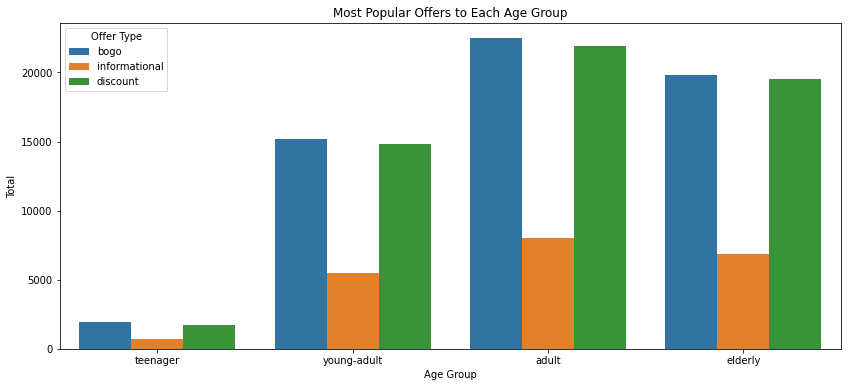

In [1001]:
plt.figure(figsize=(14, 6))
g = sns.countplot(x="age_group", hue="offer_type", data=master_dataset)
plt.title('Most Popular Offers to Each Age Group')
plt.ylabel('Total')
plt.xlabel('Age Group')
xlabels = ['teenager','young-adult','adult','elderly']
g.set_xticklabels(xlabels)
plt.xticks(rotation = 0)
plt.legend(title='Offer Type')
plt.show();

bogo and discount are the most common offer types given

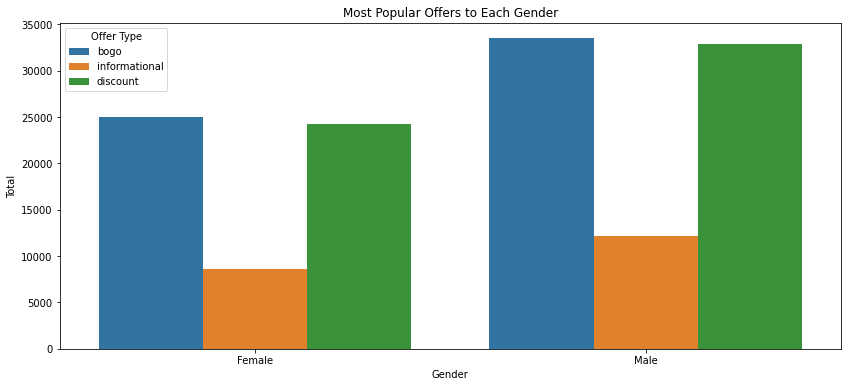

In [1002]:
plt.figure(figsize=(14, 6))
g = sns.countplot(x='gender', hue="offer_type", data= master_dataset[master_dataset["gender"] != 3])
plt.title('Most Popular Offers to Each Gender')
plt.ylabel('Total')
plt.xlabel('Gender')
xlabels = ['Female', 'Male']
g.set_xticklabels(xlabels)
plt.legend(title='Offer Type')
plt.show();

The chart we got showed that both genders like BOGO and Discount offers and they have the same reaction toward Informational offers, they both seem to be not intersted to it.

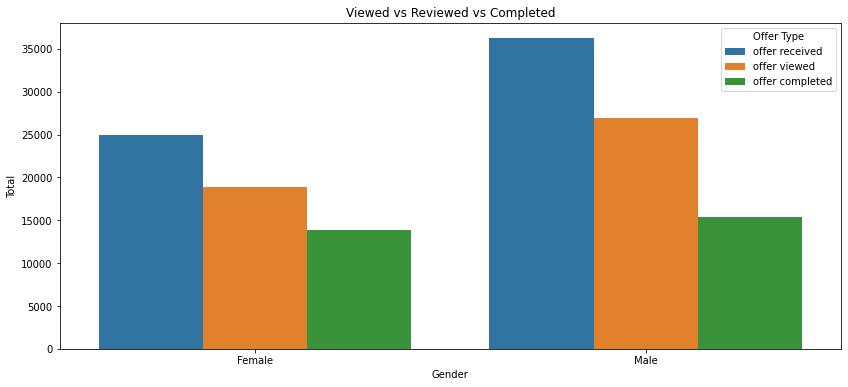

In [1003]:
plt.figure(figsize=(14, 6))
g = sns.countplot(x='gender', hue="event", data= master_dataset[master_dataset["gender"] != 3])
plt.title('Viewed vs Reviewed vs Completed')
plt.ylabel('Total')
plt.xlabel('Gender')
xlabels = ['Female', 'Male']
g.set_xticklabels(xlabels)
plt.legend(title='Offer Type')
plt.show();

The ratio of offer received, viewed, completed looks similar between male and female

### BUSINESS PROBLEM TO SOLVE

We finally have properly cleaned data, now using this cleaned data, lets try to solve a real world problem

**Problem 1**

* Find users who will make the purchase, even without the offers and find users who are mostly likely to convert when they receive an offer

**Solution**

To accomplish this, we will need to divide users into two groups.
group 1 -- users who receive -> view -> make transaction -> complete offer
group 2 -- users who receive -> make transaction
group 3 -- users who receive -> view
group 4 -- users who receive
 
Unfortunately how data is provided without timestamp of events, it is difficult to correlate, and divide users into these groups


**Problem 2**

* Find users who are mostly likely to complete bogo and discount offers, As sending offers to users has a cost, if we can identify if user is unlikely to use an offer, we can skip sending him offers and target some other users 

**Solution**

To accomplish this, we will to find percentage of bogo and discount completion done by each user. Once this is done we can train our model using various user features and can build a new model to predict if a user will successfully complete bogo/discounted offer or not
 
Achieving this will be much easier, as we have "offer received" and "offer completed" event mapped to a customer_id.

### FINAL DATA PREPARATION

In [1004]:
# we were convert the event column value into a separate column, 
# with 0 and 1 indicating, that event happened or not

master_dataset = pd.get_dummies(master_dataset , columns=['event'] , prefix='' ,prefix_sep='')
master_dataset.iloc[1]

customer_id          78afa995795e4d85b5d9ceeca43f5fef
time                                                6
offer_id             9b98b8c7a33c4b65b9aebfe6a799e6d9
amount                                            NaN
reward_transcript                                 NaN
reward_portfolio                                    5
difficulty                                          5
duration                                            7
offer_type                                       bogo
email                                               1
mobile                                              1
social                                              0
web                                                 1
duration_h                                        168
gender                                              1
age                                                75
became_member_on                  2017-05-09 00:00:00
income                                       100000.0
age_group                   

Now we will do a group by on customer_id and offer_type and save the info if user actually completed offer or not in a separate column

In [1005]:
final_model = master_dataset.groupby(['customer_id' , 'offer_type']).agg(
    {
         'offer completed':sum,   
         'offer received': sum, 
         'offer viewed': sum,  
        'age_group':'last',
        'membership_time':'last',
        'gender':'last',
        'income_scaled':'last'
    }
).reset_index()
final_model.head()

,customer_id,offer_type,offer completed,offer received,offer viewed,age_group,membership_time,gender,income_scaled
0,0009655768c64bdeb2e877511632db8f,bogo,1,1,1,2,2,2,0.466667
1,0009655768c64bdeb2e877511632db8f,discount,2,2,1,2,2,2,0.466667
2,0009655768c64bdeb2e877511632db8f,informational,0,2,2,2,2,2,0.466667
3,0011e0d4e6b944f998e987f904e8c1e5,bogo,1,1,1,2,1,3,0.300000
4,0011e0d4e6b944f998e987f904e8c1e5,discount,2,2,2,2,1,3,0.300000


In [1006]:

def mark_customer_offer_completion(df):
    '''
    this functions add columns which updates count of bogo/discount completed and recieved
    bogo and discount offers
    '''
    
    df['bogo_received'] = 0
    df['bogo_completed'] = 0

    df['discount_received'] = 0
    df['discount_completed'] = 0

    for index , row in df.iterrows():
        if(row['offer_type'] == 'bogo'):
            df.loc[index , 'bogo_completed'] = row['offer completed']
            df.loc[index , 'bogo_received'] = row['offer received']

        elif(row['offer_type'] == 'discount'):
            df.loc[index , 'discount_completed'] = row['offer completed']
            df.loc[index , 'discount_received'] = row['offer received']
        
        
    return df

In [1007]:
final_model.gender.unique()

array([2, 3, 1])

In [1008]:
final_data = mark_customer_offer_completion(final_model)


In [1009]:
final_data.gender.unique()

array([2, 3, 1])

Now we have data against user_id and offer_type, how many offers were received and further completed by the user

In [1010]:
final_data.shape

(32946, 13)

In [1011]:
final_data.isna().sum()

customer_id           0
offer_type            0
offer completed       0
offer received        0
offer viewed          0
age_group             0
membership_time       0
gender                0
income_scaled         0
bogo_received         0
bogo_completed        0
discount_received     0
discount_completed    0
dtype: int64

Lets find percentage of converstion and add new columns for that

In [1012]:
final_data['bogo_percentage'] = final_data.bogo_completed.div(final_data.bogo_received.where(final_data.bogo_received != 0, np.nan))*100
final_data['discount_percentage'] = final_data.discount_completed.div(final_data.discount_received.where(final_data.discount_received != 0, np.nan))*100

final_data.head(10)



,customer_id,offer_type,offer completed,offer received,offer viewed,age_group,membership_time,gender,income_scaled,bogo_received,bogo_completed,discount_received,discount_completed,bogo_percentage,discount_percentage
0,0009655768c64bdeb2e877511632db8f,bogo,1,1,1,2,2,2,0.466667,1,1,0,0,100.0,NaN
1,0009655768c64bdeb2e877511632db8f,discount,2,2,1,2,2,2,0.466667,0,0,2,2,NaN,100.0
2,0009655768c64bdeb2e877511632db8f,informational,0,2,2,2,2,2,0.466667,0,0,0,0,NaN,NaN
3,0011e0d4e6b944f998e987f904e8c1e5,bogo,1,1,1,2,1,3,0.300000,1,1,0,0,100.0,NaN
4,0011e0d4e6b944f998e987f904e8c1e5,discount,2,2,2,2,1,3,0.300000,0,0,2,2,NaN,100.0
5,0011e0d4e6b944f998e987f904e8c1e5,informational,0,2,2,2,1,3,0.300000,0,0,0,0,NaN,NaN
6,0020c2b971eb4e9188eac86d93036a77,bogo,1,2,1,3,3,1,0.666667,2,1,0,0,50.0,NaN
7,0020c2b971eb4e9188eac86d93036a77,discount,2,2,1,3,3,1,0.666667,0,0,2,2,NaN,100.0
8,0020c2b971eb4e9188eac86d93036a77,informational,0,1,1,3,3,1,0.666667,0,0,0,0,NaN,NaN
9,0020ccbbb6d84e358d3414a3ff76cffd,bogo,2,2,2,2,2,1,0.333333,2,2,0,0,100.0,NaN


In [1013]:
final_data.fillna(0, inplace=True)


Now that we have data in percetage, we need to choose a percetage which we consider as success before we feed in this value to our machine learning model

According to me, if 2 out of 3 conversion is done by any user, that can be considered as a success event.


In [1014]:
final_data['bogo_send'] = 0
final_data['discount_send'] = 0


for i ,row in final_data.iterrows():

    if(row['bogo_percentage'] >= 66):
        final_data.loc[i , 'bogo_send'] = 1
        
    if(row['discount_percentage'] >= 66 ):
        final_data.loc[i , 'discount_send'] = 1


### MODELING

In [1015]:
final_data.columns

Index(['customer_id', 'offer_type', 'offer completed', 'offer received',
       'offer viewed', 'age_group', 'membership_time', 'gender',
       'income_scaled', 'bogo_received', 'bogo_completed', 'discount_received',
       'discount_completed', 'bogo_percentage', 'discount_percentage',
       'bogo_send', 'discount_send'],
      dtype='object')

In [1016]:
required_columns = ['age_group', 'membership_time', 'gender',
       'income_scaled', 'bogo_send', 'discount_send']

In [1017]:
required_data = final_data[required_columns]
required_data.head()

,age_group,membership_time,gender,income_scaled,bogo_send,discount_send
0,2,2,2,0.466667,1,0
1,2,2,2,0.466667,0,1
2,2,2,2,0.466667,0,0
3,2,1,3,0.300000,1,0
4,2,1,3,0.300000,0,1


In [1018]:

y_bogo = required_data.bogo_send
y_discount = required_data.discount_send
required_data.drop(columns=['bogo_send', 'discount_send'], inplace=True)

/Users/nitinagarwal/Library/Python/3.7/lib/python/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [1019]:
# we will use this to test various classifiers and
# also print accuracy of the model
def train_test(clf, X_train,  X_test, y_train, y_test):
    """
    Return train and test F1 score along with the model name
       
    Parameters
    --------
    clf: estimator instance
    X_train: training dataset 
    X_test: training labe
    y_train:
    y_test:
    
    Returns
    --------
    train_f1: train data F1 score
    test_f1: test data F1 score
    name: model name
       
    """
    train_prediction =  (clf.fit(X_train, y_train)).predict(X_train)
    test_predictions = (clf.fit(X_train, y_train)).predict(X_test)
    train_f1 =  accuracy_score(y_train, train_prediction)*100
    test_f1= fbeta_score(y_test, test_predictions, beta = 0.5, average='micro' )*100
#     print (train_f1, test_f1)
    return train_f1, test_f1

In [1020]:
X_train, X_test, y_bogo_train, y_bogo_test = train_test_split(required_data, y_bogo, random_state=42)
X_train, X_test, y_discount_train, y_discount_test = train_test_split(required_data, y_discount, random_state=42)

**1. SVC Model**

In [1021]:
model_bogo = SVC()
train_f1, test_f1 = train_test(model_bogo, X_train, X_test, y_bogo_train, y_bogo_test)
print ('BOGO OFFER F1 score {}'.format(train_f1))
print ('BOGO OFFER TEST F1 score {}'.format(test_f1))

model_disc = SVC()
train_f1, test_f1 = train_test(model_disc, X_train, X_test, y_discount_train, y_discount_test)
print ('Disc OFFER F1 score {}'.format(train_f1))
print ('Disc OFFER TEST F1 score {}'.format(test_f1))

/Users/nitinagarwal/Library/Python/3.7/lib/python/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/nitinagarwal/Library/Python/3.7/lib/python/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


BOGO OFFER F1 score 80.98668501355782
BOGO OFFER TEST F1 score 81.8623285176642


/Users/nitinagarwal/Library/Python/3.7/lib/python/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/nitinagarwal/Library/Python/3.7/lib/python/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Disc OFFER F1 score 78.45319519203528
Disc OFFER TEST F1 score 78.26878717979847


**2. RandomForestClassifier**

In [1022]:
model_bogo = RandomForestClassifier(random_state = 10)
train_f1, test_f1 = train_test(model_bogo, X_train, X_test, y_bogo_train, y_bogo_test)
print ('BOGO OFFER F1 score {}'.format(train_f1))
print ('BOGO OFFER TEST F1 score {}'.format(test_f1))

model_disc = RandomForestClassifier(random_state = 10)
train_f1, test_f1 = train_test(model_disc, X_train, X_test, y_discount_train, y_discount_test)
print ('Disc OFFER F1 score {}'.format(train_f1))
print ('Disc OFFER TEST F1 score {}'.format(test_f1))

/Users/nitinagarwal/Library/Python/3.7/lib/python/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


BOGO OFFER F1 score 81.13642802217815
BOGO OFFER TEST F1 score 80.17482092995023


/Users/nitinagarwal/Library/Python/3.7/lib/python/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Disc OFFER F1 score 78.63531506738435
Disc OFFER TEST F1 score 76.08352555542066


**3. AdaBoostClassifier Model**

In [1023]:
model_bogo = AdaBoostClassifier()
train_f1, test_f1 = train_test(model_bogo, X_train, X_test, y_bogo_train, y_bogo_test)
print ('BOGO OFFER F1 score {}'.format(train_f1))
print ('BOGO OFFER TEST F1 score {}'.format(test_f1))

model_disc = AdaBoostClassifier()
train_f1, test_f1 = train_test(model_disc, X_train, X_test, y_discount_train, y_discount_test)
print ('Disc OFFER F1 score {}'.format(train_f1))
print ('Disc OFFER TEST F1 score {}'.format(test_f1))

BOGO OFFER F1 score 80.98668501355782
BOGO OFFER TEST F1 score 81.83804783294889
Disc OFFER F1 score 78.45319519203528
Disc OFFER TEST F1 score 78.26878717979847


### RESULTS

We tried three classification models. Out of the 3 **SVC** performs the best but only marginally.

Using gridSearch and trying different parameters can further improve accuracy of the model

### Conclusion

The model uses user features like age, income, gender and membership time with startbucks to predict if a customers is sent a promotion out the type bogo or discount, how likely he is to actually do a transaction after using the offer.

Since sending out these offers costs the company, and it is also possible that some customers may do transactions irrespective of offers. 

We can use this model, to effectively send out these offers to those customers who we think will actually convert.

After running the model we found that we have
1. SVC perfoming the best amongst all the models we tested on(SVC, RandomForestClassifier, AdaBoostClassifier)
2. These models can predict with approx 80% accuracy if an offer is received by the customer, if they will actually do a transaction and complete the offer.
